In [28]:
import pandas as pd
import os
from nltk.tokenize import RegexpTokenizer
import ast
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.pipeline import make_pipeline
import matplotlib.patches as mpatches
import matplotlib
from sklearn.decomposition import PCA, TruncatedSVD
import random
from collections import defaultdict


import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

import gensim

from lime import lime_text
from lime.lime_text import LimeTextExplainer

pd.set_option("display.max_colwidth", 80)

%matplotlib inline

In [2]:
word2vec_path = "~/data/reference/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [3]:
df_trn = pd.read_csv("/home/ubuntu/data/cleaned/disaster_response_messages_training.csv", dtype={"split": str, "message": str, "original": str, "genre": str})
df_trn["tokens"] = df_trn["tokens"].apply(ast.literal_eval)
df_trn = df_trn.sample(frac=1.0, random_state=42)
df_trn.head(40)

,Unnamed: 0,id,split,message,original,genre,related,PII,request,offer,...,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,message_std,tokens
16944,16944,24527,train,This week the government launched a 100-million-dollar climate resilience pr...,NaN,news,1,0,0,0,...,0,0,0,0,0,0,0,0,this week the government launched a 100 million dollar climate resilience pr...,"[this, week, the, government, launched, a, 100, million, dollar, climate, re..."
20803,20803,29923,train,"Whatever the political calculations in Jakarta, disgruntled residents here b...",NaN,news,1,0,1,0,...,0,0,0,0,0,0,0,1,"whatever the political calculations in jakarta, disgruntled residents here b...","[whatever, the, political, calculations, in, jakarta, disgruntled, residents..."
6836,6836,9512,train,Bases insolubles Cu(OH)2-Fe(OH)3-Cr(OH)2-CuOH-Zn(OH)2-Al(OH)3-Pb(OH)2 Base I...,Bases insolubles Cu ( OH ) 2-Fe ( OH ) 3-Cr ( OH ) 2-CuOH-Zn ( OH ) 2-Al ( O...,direct,0,0,0,0,...,0,0,0,0,0,0,0,0,bases insolubles cu(oh)2 fe(oh)3 cr(oh)2 cuoh zn(oh)2 al(oh)3 pb(oh)2 base i...,"[bases, insolubles, cu, oh, 2, fe, oh, 3, cr, oh, 2, cuoh, zn, oh, 2, al, oh..."
5865,5865,8227,train,I want to get contact with an Organisation (ONG) to let it know that I have ...,Mwen bezwen antre an kontak ak 0NG paske m gen anpil problem ak moun ki mala...,direct,1,0,1,0,...,0,0,0,0,0,0,0,1,i want to get contact with an organisation (ong) to let it know that i have ...,"[i, want, to, get, contact, with, an, organisation, ong, to, let, it, know, ..."
7628,7628,10665,train,"The SMS: Hello at you operators, I will ask you for information. Is there wo...","Bonjour vous operateurs,je vais vous demander une information.Est qu'il aur...",direct,1,0,0,0,...,0,0,0,0,0,0,0,0,"the sms hello at you operators, i will ask you for information is there wo...","[the, sms, hello, at, you, operators, i, will, ask, you, for, information, i..."
11968,11968,17622,train,The China Meteorological Administration issued a red alert early that day fo...,NaN,news,1,0,0,0,...,0,0,0,0,0,0,0,0,the china meteorological administration issued a red alert early that day fo...,"[the, china, meteorological, administration, issued, a, red, alert, early, t..."
11062,11062,16382,train,"In the Philippines, millions of terrified flood survivors, many of them shel...",NaN,news,1,0,0,0,...,1,1,1,0,0,0,0,0,"in the philippines, millions of terrified flood survivors, many of them shel...","[in, the, philippines, millions, of, terrified, flood, survivors, many, of, ..."
6024,6024,8431,train,"If I have diarrhe what can I do,I am a survivor",Si m gen kolerin kisa pou m fe m se yon riskape,direct,1,0,1,0,...,0,0,0,0,0,0,0,1,"if i have diarrhe what can i do,i am a survivor","[if, i, have, diarrhe, what, can, i, do, i, am, a, survivor]"
11216,11216,16587,train,The engineers have trained thousands of people to build and design their hou...,NaN,news,1,0,0,0,...,0,0,0,0,0,0,0,0,the engineers have trained thousands of people to build and design their hou...,"[the, engineers, have, trained, thousands, of, people, to, build, and, desig..."
17064,17064,24686,train,Assessment missions by government authorities were conducted in extremely di...,NaN,news,0,0,0,0,...,0,0,0,0,0,0,0,0,assessment missions by government authorities were conducted in extremely di...,"[assessment, missions, by, government, authorities, were, conducted, in, ext..."


In [4]:
df_val = pd.read_csv("/home/ubuntu/data/cleaned/disaster_response_messages_validation.csv", dtype={"split": str, "message": str, "original": str, "genre": str})
df_val["tokens"] = df_val["tokens"].apply(ast.literal_eval)
df_val.head()

,Unnamed: 0,id,split,message,original,genre,related,PII,request,offer,...,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,message_std,tokens
0,0,8,validation,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ak timoun yo. Mesi se john jea...",direct,1,0,0,0,...,0,0,0,0,0,0,0,0,looking for someone but no name,"[looking, for, someone, but, no, name]"
1,1,18,validation,I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in S...,"Nou kwadebouke, nou gen pwoblem sant m yo nan santo 15",direct,1,0,1,0,...,0,0,0,0,0,0,0,1,i am in croix des bouquets we have health issues they ( workers ) are in s...,"[i, am, in, croix, des, bouquets, we, have, health, issues, they, workers, a..."
2,2,28,validation,are you going to call me or do you want me to call ou? let me know?,Eske se rele nap relem oubyen se mwen kap rele nou?si se mwen eske,direct,0,0,0,0,...,0,0,0,0,0,0,0,0,are you going to call me or do you want me to call ou? let me know?,"[are, you, going, to, call, me, or, do, you, want, me, to, call, ou, let, me..."
3,3,38,validation,"People I'm at Delma 2, we don't anything what so ever, please provide us wit...",MEZANMI MWEN MWEN NAN DELMA 2 NOU TR MAN MAL NOU PA JAN M JWEN ANY,direct,1,0,1,0,...,0,0,0,0,0,0,0,1,"people i'm at delma 2, we don't anything what so ever, please provide us wit...","[people, i, m, at, delma, 2, we, don, t, anything, what, so, ever, please, p..."
4,4,48,validation,"How we can find food and water? we have people in many differents needs, and...",Comment nou ka jwen dlo ak manje nou gen moun ki gen tout kalte pwoblem nan ...,direct,1,0,0,0,...,0,0,0,0,0,0,0,0,"how we can find food and water? we have people in many differents needs, and...","[how, we, can, find, food, and, water, we, have, people, in, many, different..."


In [5]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, df, generate_missing=False):
    embeddings = df['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [6]:
X_trn_w2v = get_word2vec_embeddings(word2vec, df_trn)
X_val_w2v = get_word2vec_embeddings(word2vec, df_val)
y_trn_w2v = df_trn["related"]
y_val_w2v = df_val["related"]


In [7]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

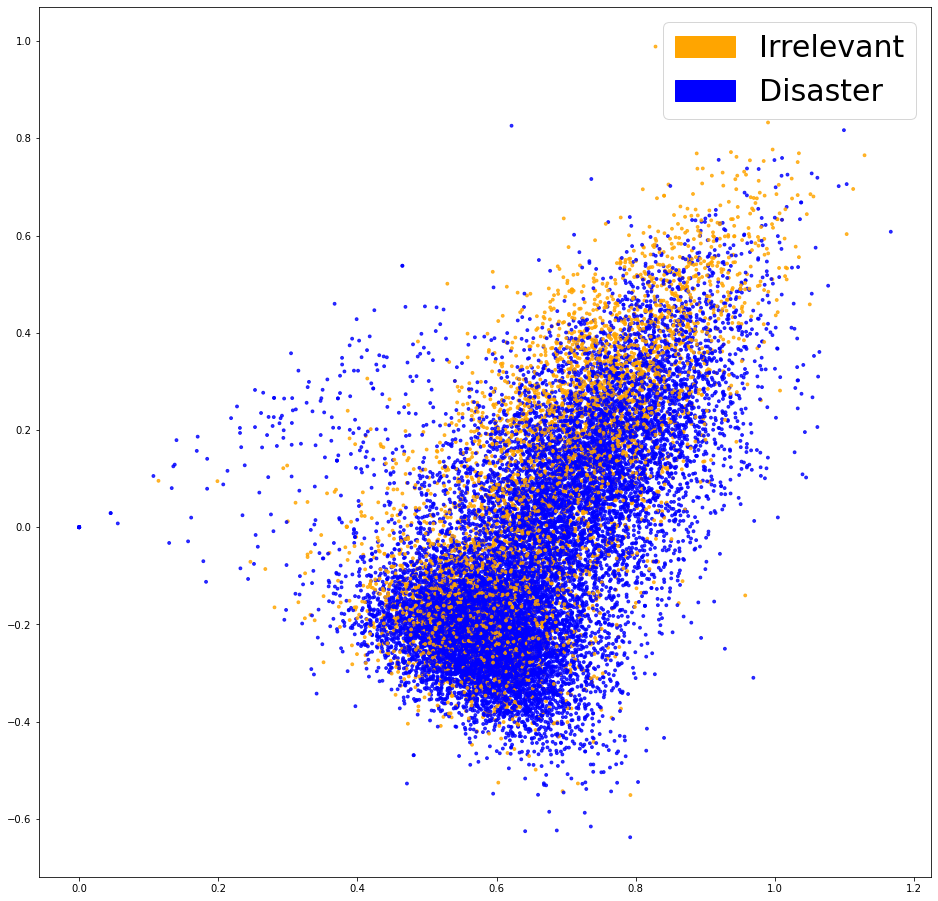

In [8]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_trn_w2v, y_trn_w2v)
plt.show()

In [9]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf_w2v.fit(X_trn_w2v, y_trn_w2v)

y_prd_w2v = clf_w2v.predict(X_val_w2v)

In [10]:
def get_metrics(y_truth, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_truth, y_predicted, pos_label=None, average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_truth, y_predicted, pos_label=None, average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_truth, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_truth, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_val_w2v, y_prd_w2v)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.770, precision = 0.830, recall = 0.770, f1 = 0.788


In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

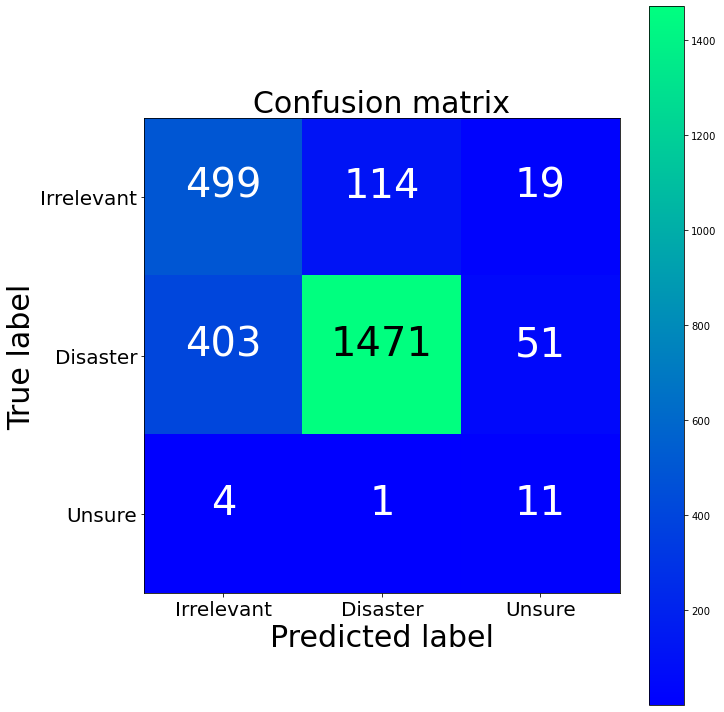

[[ 499  114   19]
 [ 403 1471   51]
 [   4    1   11]]


In [12]:
cm = confusion_matrix(y_val_w2v, y_prd_w2v)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

## Use Lime to find most important features for word2vec-enabled model

In [17]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(df_trn["message_std"])

CountVectorizer()

In [18]:
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf_w2v)

In [19]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["irrelevant","relevant", "unknown"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [23]:
visualize_one_exp(df_val["message_std"], df_val["related"], 65)

Index: 65
True class: relevant


In [27]:
visualize_one_exp(df_val["message_std"], df_val["related"], 2)

Index: 2
True class: irrelevant


In [26]:
df_val["related"]

0       1
1       1
2       0
3       1
4       1
       ..
2568    1
2569    1
2570    1
2571    0
2572    0
Name: related, Length: 2573, dtype: int64

In [30]:
random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Irrelevant',
    1: 'Relevant',
    2: 'Unsure'
}
sorted_contributions = get_statistical_explanation(list(df_val["message_std"]), 100, word2vec_pipeline, label_to_text)

<ipython-input-30-7bd17d3e5475>:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())


In [32]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Disaster', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()


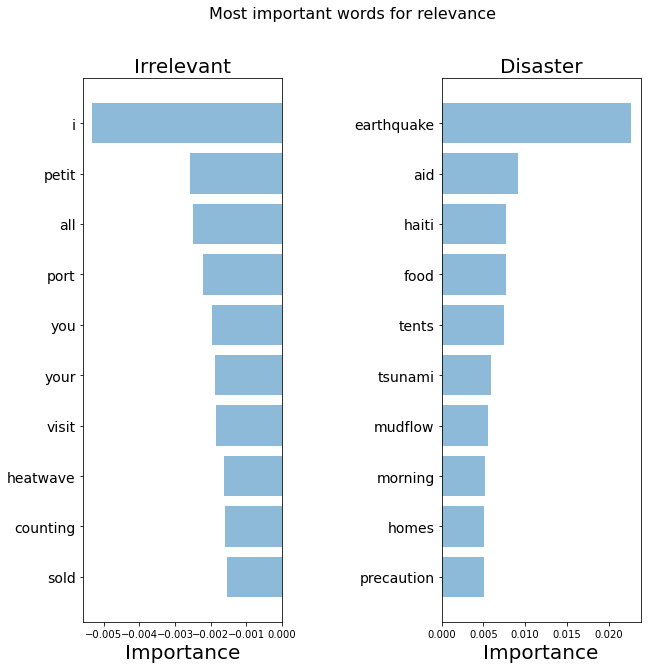

In [33]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")